In [14]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pygmt
from netCDF4 import Dataset

In [ ]:
# config
dir_data = "data_Tohoku"
dir_result = "result_Tohoku"

fname_station_name = "share/Snet133.txt"
fname_station_lonlat = "share/Snet133_lonlat.txt"

scale = 8
scale_flux = 500

lon_min = 140.5
lon_max = 146.5
lat_min = 34.0
lat_max = 42.0
Nlon = 1201
Nlat = 1601

In [ ]:
# station
with open(fname_station_name) as f:
    Stations = [s.rstrip() for s in f.readlines()]

Nst = len(Stations)

lonlat_st = np.loadtxt(fname_station_lonlat)
lon_st = lonlat_st[:,0]
lat_st = lonlat_st[:,1]

In [13]:
# estimated waveform

os.makedirs(dir_result + "/estimated_waveforms_png", exist_ok=True)

Nt = 121
ts = np.linspace(0, 20, Nt)

scale = 10 
SN = 10

for ist in range(Nst):
    station = Stations[ist]

    eta_true = np.loadtxt(dir_data+f"/tgs_filtered_SN{SN}/{station}.txt")[0:Nt]
    eta_est = np.loadtxt(dir_result+f"/estimated_waveforms/{station}.txt")

    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(ts, eta_true, label="Ground Truth", color="dimgray")
    ax.plot(ts, eta_est, label="PINN Estimation", color="r")
    ax.set_ylim(-scale,scale)
    ax.set_xlabel("Time [min]")
    ax.set_ylabel("Height [m]")
    ax.set_title(station)
    ax.legend()
    plt.savefig(dir_result+f"/estimated_waveforms_png/{station}.png")
    plt.close()


In [7]:
# snapshot of eta

Nt_test = 21

for i in range(Nt_test):
    fig = pygmt.Figure()
    pygmt.makecpt(cmap='polar', series=[-scale, scale, 1], continuous=True, background="")
    im = fig.grdimage(
        grid=dir_result+f"/eta_estimated/eta_estimated_{i}.grd", 
        projection="M12c", 
        frame=['WSen+tEstimated eta', 'xaf', 'yaf']
    )
    fig.coast(
        region=[lon_min, lon_max, lat_min, lat_max],
        projection="M12c",
        land='125/125/125',
        area_thresh=100,
        shorelines='default,black',
    )
    fig.plot(x=lon_st, y=lat_st, style="c0.2c", fill="black")
    fig.text(
        x=lon_max-1, y=lat_min+0.3, font="18p,Helvetica-Bold",
        text=f"t = {i:4.1f} min"
    )
    fig.colorbar(cmap='polar', position="JBC", frame='x+l[m]', scale=scale)
    fig.savefig(dir_result+f"/eta_estimated/eta_estimated_{i}.png")

In [8]:
# snapshot of M

for i in range(Nt_test):
    fig = pygmt.Figure()
    pygmt.makecpt(cmap='polar', series=[-scale_flux, scale_flux, 1], continuous=True, background="")
    im = fig.grdimage(
        grid=dir_result+f"/M_estimated/M_estimated_{i}.grd", 
        projection="M12c", 
        frame=['WSen+tEstimated M', 'xaf', 'yaf']
    )
    fig.coast(
        region=[lon_min, lon_max, lat_min, lat_max],
        projection="M12c",
        land='125/125/125',
        area_thresh=100,
        shorelines='default,black',
    )
    fig.plot(x=lon_st, y=lat_st, style="c0.2c", fill="black")
    fig.text(
        x=lon_max-1, y=lat_min+0.3, font="18p,Helvetica-Bold",
        text=f"t = {i:4.1f} min"
    )
    fig.colorbar(cmap='polar', position="JBC", frame='x+l[m^2/s]', scale=scale_flux)
    fig.savefig(dir_result+f"/M_estimated/M_estimated_{i}.png")

In [9]:
# shanpshot of N

for i in range(Nt_test):
    fig = pygmt.Figure()
    pygmt.makecpt(cmap='polar', series=[-scale_flux, scale_flux, 1], continuous=True, background="")
    im = fig.grdimage(
        grid=dir_result+f"/N_estimated/N_estimated_{i}.grd", 
        projection="M12c", 
        frame=['WSen+tEstimated N', 'xaf', 'yaf']
    )
    fig.coast(
        region=[lon_min, lon_max, lat_min, lat_max],
        projection="M12c",
        land='125/125/125',
        area_thresh=100,
        shorelines='default,black',
    )
    fig.plot(x=lon_st, y=lat_st, style="c0.2c", fill="black")
    fig.text(
        x=lon_max-1, y=lat_min+0.3, font="18p,Helvetica-Bold",
        text=f"t = {i:4.1f} min"
    )
    fig.colorbar(cmap='polar', position="JBC", frame='x+l[m^2/s]', scale=scale_flux)
    fig.savefig(dir_result+f"/N_estimated/N_estimated_{i}.png")

In [10]:
# VRs of (eta, M, N)

def RelativeError(A_pred, A_true):
    return np.linalg.norm(A_pred-A_true) / np.linalg.norm(A_true)

def VarianceReduction(A_pred, A_true):
    rel_error = RelativeError(A_pred, A_true)
    return 100 * (1-rel_error**2)

def read_grd(fname):
    dataset = Dataset(fname,'r')
    grd = dataset.variables['z'][:]
    grd = grd.reshape((Nlat, Nlon))
    grd = np.flipud(grd)
    return grd


D = read_grd(f'share/tohoku.grd')
mask = D>0


with open(dir_result+"/VRs.txt", 'w') as f:
    f.write("time[min] VR_eta VR_M VR_N\n")

    for i in range(Nt_test):
        i2 = str(600*i).zfill(8)

        # eta
        eta_true = read_grd(dir_data+f'/snap_grd/SD01.{i2}.grd')
        eta_PINN = read_grd(dir_result+f'/eta_estimated/eta_estimated_{i}.grd')
        VR_eta = VarianceReduction(eta_PINN[mask], eta_true[mask])

        # M
        vx_true = read_grd(dir_data+f'/snap_grd/SD01.{i2}-vx.grd')
        M_true = D * vx_true
        M_PINN = read_grd(dir_result+f'/M_estimated/M_estimated_{i}.grd')
        VR_M = VarianceReduction(M_PINN[mask], M_true[mask])

        # N
        vy_true = read_grd(dir_data+f'/snap_grd/SD01.{i2}-vy.grd')
        N_true = -D * vy_true
        N_PINN = read_grd(dir_result+f'/N_estimated/N_estimated_{i}.grd')
        VR_N = VarianceReduction(N_PINN[mask], N_true[mask])
            
        f.write(f"{i} {VR_eta} {VR_M} {VR_N}\n")

/tmp/ipykernel_4011819/3241484782.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return np.linalg.norm(A_pred-A_true) / np.linalg.norm(A_true)


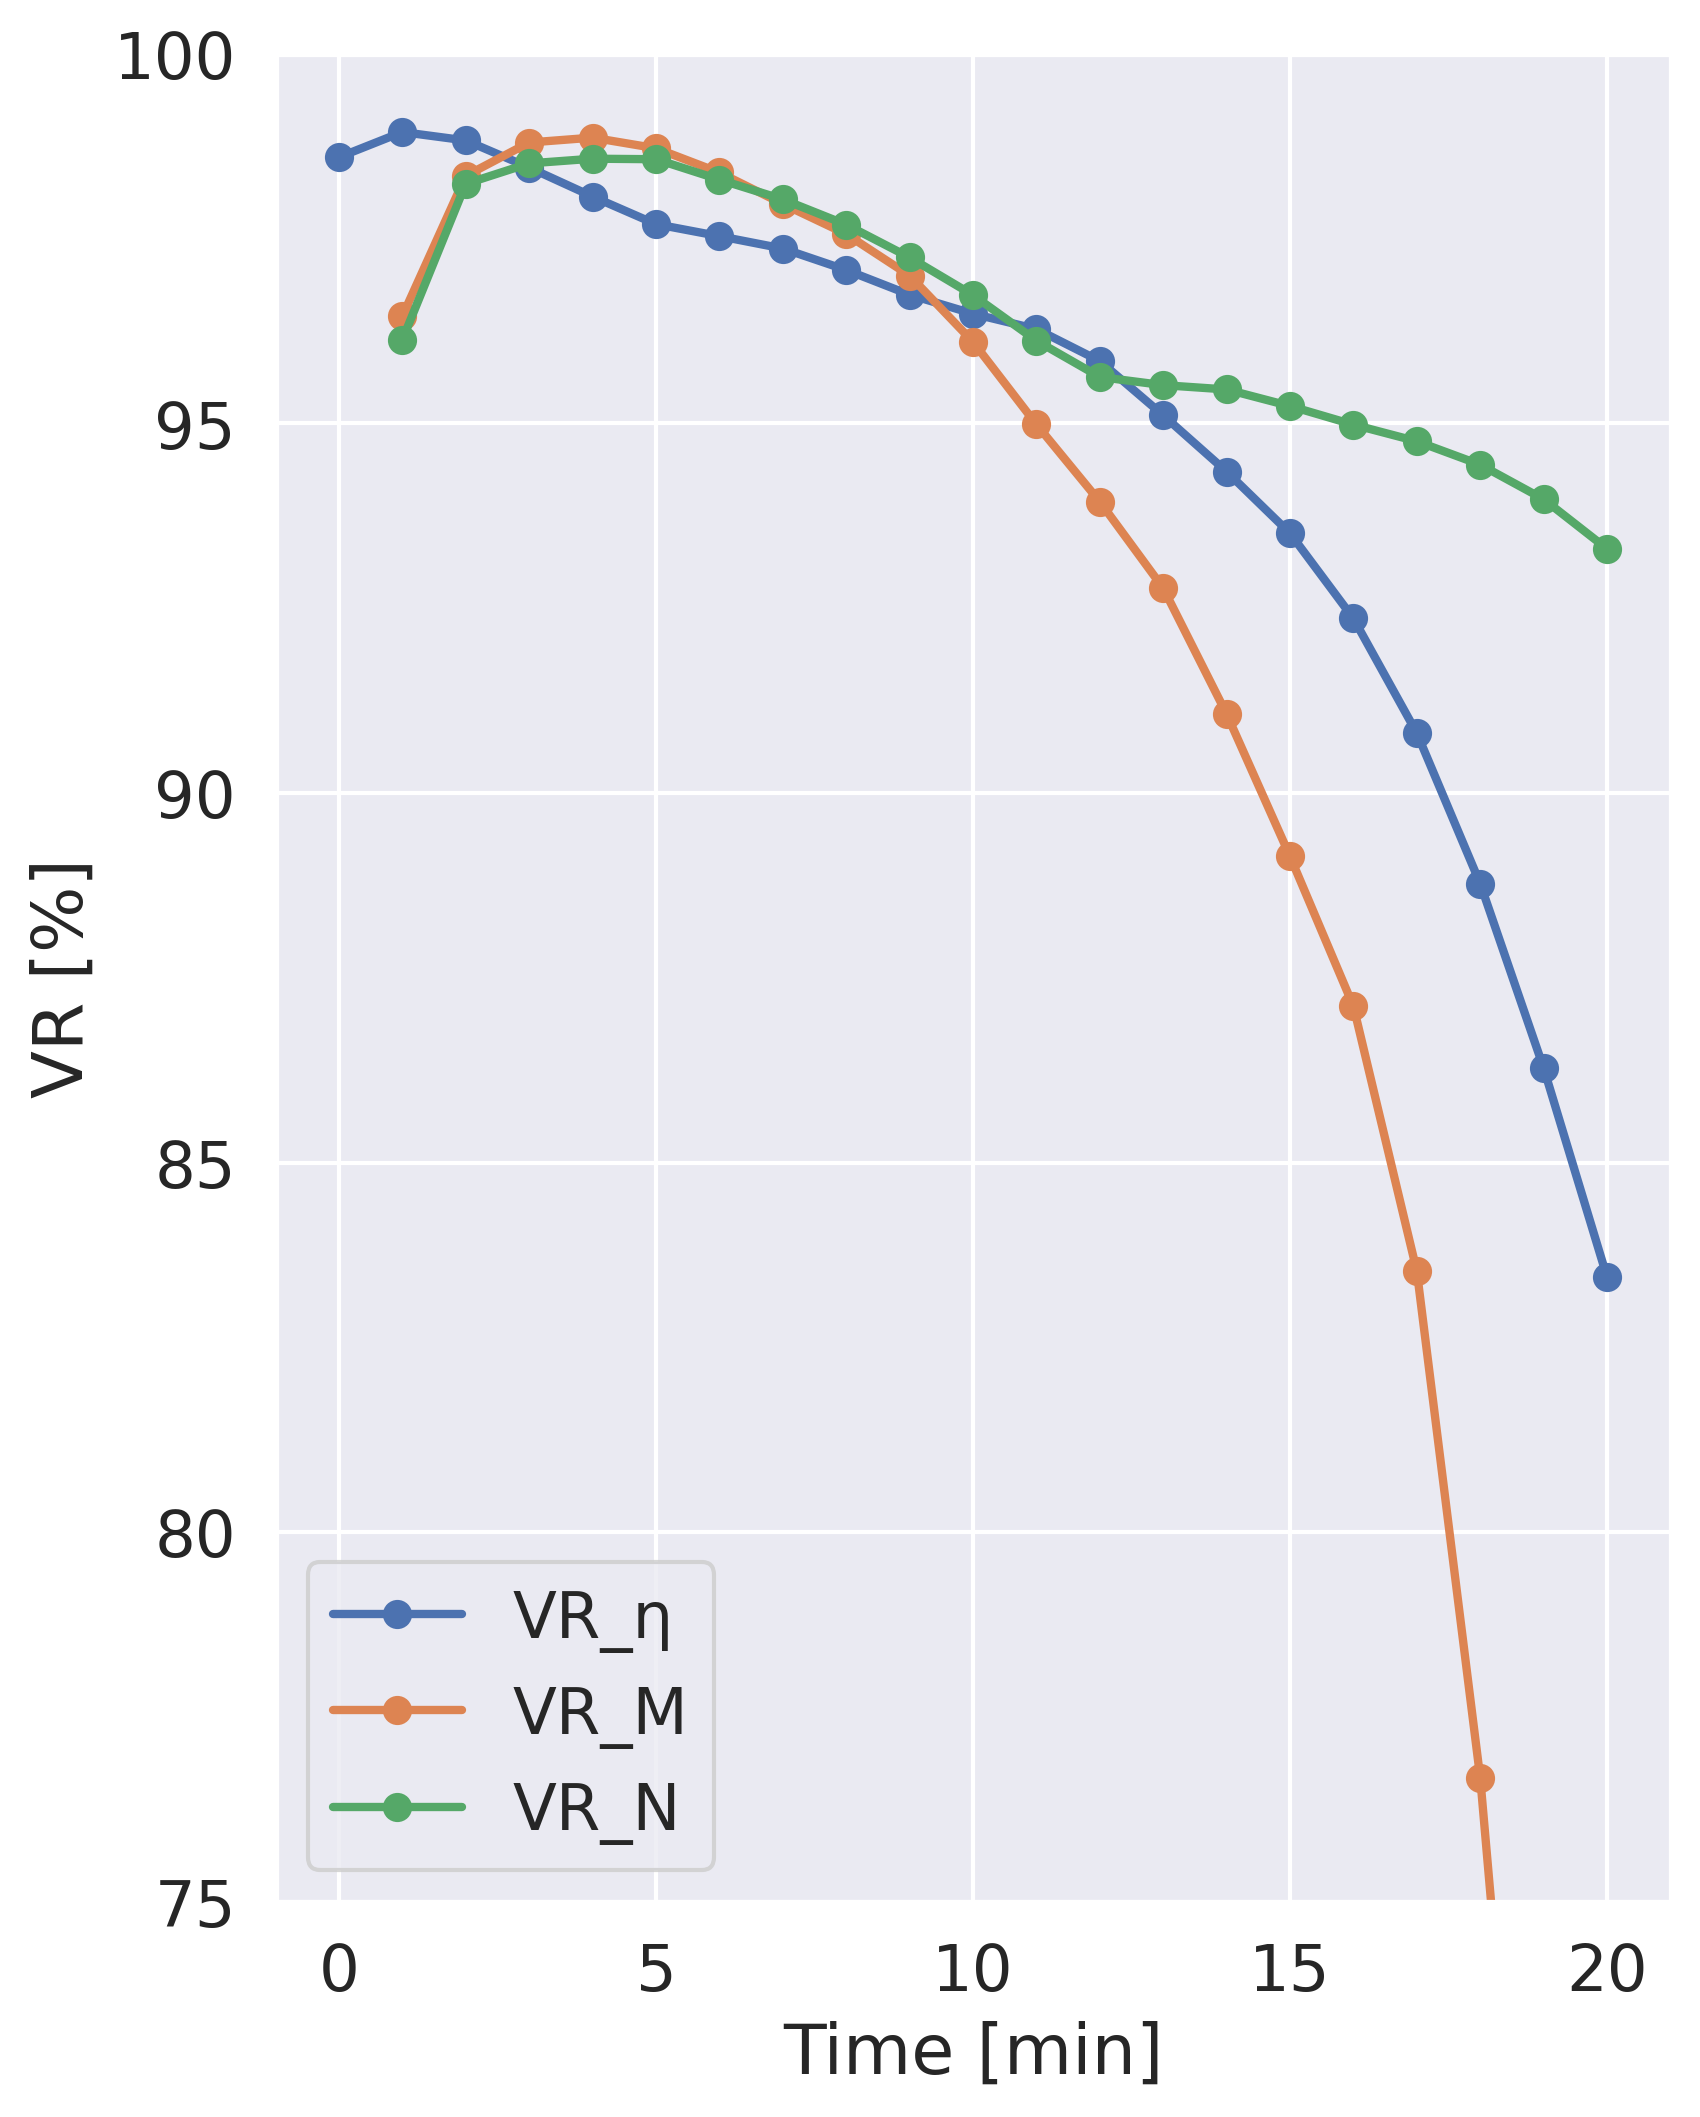

In [15]:
VRs = np.loadtxt(dir_result+"/VRs.txt", skiprows=1)
ts = VRs[:,0]
VRs_eta = VRs[:,1]
VRs_M = VRs[:,2]
VRs_N = VRs[:,3]

sns.set(font_scale=1.4)
plt.rcParams["font.size"] = 18
fig, ax = plt.subplots(figsize=(6,8), dpi=300)
ax.plot(ts, VRs_eta, "-o", lw=2, label="VR_η")
ax.plot(ts, VRs_M, "-o", lw=2, label="VR_M")
ax.plot(ts, VRs_N, "-o", lw=2, label="VR_N")
ax.set_xlabel("Time [min]")
ax.set_ylabel("VR [%]")
ax.set_ylim([75,100])
ax.legend()
plt.savefig(dir_result+"/VRs.png", bbox_inches='tight')